# This notebook contains step-by-step instructions for using Dropseqtools 2.3

- The following notebook contains instructions for aligning reads generated from SeqWell/DropSeq protocols. Much of this is taken directly from the McCarroll Lab's [alignment cookbook](https://github.com/broadinstitute/Drop-seq/blob/master/doc/Drop-seq_Alignment_Cookbook.pdf), with copied items being *italicized*. Here, we will run Dropseqtools on data from the first batch of data on mouse retina from the Macosko et al., 2015 paper.

- We downloaded and downsampled to 10% of the first batch of cells (~50 Million Reads) in order to be able to process it interactively in a timely manner.

# Getting started:

We have downloaded all the published data and other files you might need for this and other sessions. In order to get access to these files you can create a softlink to the folder:

```bash
cd ~
ln -s /oasis/tscc/scratch/CSHL_single_cell_2019 ./
```

Finally, we will make another softlink in your home to your own scratch folder, and copy the relevant files:

```bash
cd ~
ln -s /oasis/tscc/scratch/ucsd-trainXX/ ./scratch
cp CSHL_single_cell_2019/P14_mouse_retina_data/SRR1853178_downsampled_R*.fastq.gz ./scratch/
```

NOTE: Remember to use your own ucsd-train## (i.e. ucsd-train27)

# Interactive Jobs:
For dropseqtools we will be working with interactive jobs in order to visualize on real time the progress of each processing step as we go through the analysis. We have allocated Yeo Lab cluster resources for our use throughout the course. To request an interactive job:
```bash
qsub -I -l walltime=8:00:00 -q home-yeo -l nodes=1:ppn=2
```

keep in mind that you can adjust your ```walltime=H:MM:SS ``` as necessary.

# cd ~/scratch

On our cluster (and typically for others as well), data processing is typically done inside a scratch folder, since working with big data can create large intermediates. Therefore we'll be doing all of this work inside scratch: 

```bash
cd ~/scratch
```

# Loading the module:
By this point you should have completed the onboarding notebooks and are familiar with loading and unloading TSCC modules. Let's load the dropseqtools module which gives you access to the dropseqtools scripts.

```bash
module load dropseqtools/2.3.0
```

### Step 00: Preprocessing
*The raw reads from the sequencer must be converted into a Picard queryname sorted BAM file for
each library in the sequencer run. Since there are many sequencers and pipelines available to do
this, we leave this step to the user. For example, we use either Picard IlluminaBasecallsToSam
(preceded by Picard ExtractIlluminaBarcodes for a library with sample barcodes);  or Illumina’s
bcl2fastq followed by Picard FastqToSam.  Once you have an unmapped, queryname sorted BAM, you
can follow this set of steps to align your raw reads and create a BAM file that is suitable to produce
digital gene expression (DGE) results.*

BAM files are typically known for storing alignment data, or reads that have been aligned to a reference. **However, this format can also store reads that are unaligned** (just like fastq.gz files), and there are exists some tools (including the ones referenced in this notebook) that use the BAM file format to store unaligned reads.

So before proceeding, we will need to convert fastq.gz files to their BAM file equivalents (in this example, we will call our bam file ```my_unaligned_data.bam``` and will be used as an input into the next step:

```bash
picard FastqToSam \
F1=forward_reads.fastq \
F2=reverse_reads.fastq \
O=my_unaligned_data.bam \
SM=sample001 \
```

**Note:** the backslash (```\```) after each line indicates the continuation of a command on the next line.

# Alignment overview:
- Unmapped BAM > aligned and tagged BAM
- Tag cell barcodes
- Tag molecular barcodes
- Trim 5’ primer sequence
- Trim 3’ polyA sequence
- SAM > Fastq
- STAR alignment
- Sort STAR alignment in queryname order
- Merge STAR alignment tagged SAM to recover cell/molecular barcodes
- Add gene/exon and other annotation tags
- Barcode repair:
    - DetectBeatSubstitutionErrors
    - DetectBeadSynthesisErrors

### Metadata:

- **fasta**: *The reference sequence of the organism. Needed for most aligners.*
- **dict**: A dictionary file as generated by Picard’s CreateSequenceDictionary. Needed for Picard
Tools.*
- **gtf**: *The principle file to determine the location of genomic features like genes, transcripts,
and exons. Many other metadata files we use derive from this original file. We download our
GTF files from ensembl, which has a handy description of the file format here. Ensembl has a
huge number of prepared GTF files for a variety of organisms here.*
- **refFlat**: *This file contains a subset of the the same information in the GTF file in a different
format. Picard tools like the refFlat format, so we require this as well. To make life easy, we
provide a program ConvertToRefFlat that can convert files from GTF format to refFlat for you.*
- **genes.intervals**: *The genes from the GTF file in interval list format. This file is optional, and
useful if you want to go back to your BAM later to see what gene(s) a read aligns to.*
- **exons.intervals**: *The exons from the GTF file in interval list format. This file is optional, and
useful if you want to go back to your BAM and view what exon(s) a read aligns to.*
- **rRNA.intervals**: *The locations of ribosomal RNA in interval list format. This file is optional, but
we find it useful to later assess how much of a dropseq library aligns to rRNA.*
- **reduced.gtf**: *This file contains a subset of the information in the GTF file, but in a far more
human readable format. This file is optional, but can be generated easily by the supplied
ReduceGTF program that will take a GTF file as input.*

### Step 01: TagBamWithReadsSequenceExtended (tag cells)

*This Drop-seq program extracts bases from the cell/molecular barcode encoding read **(BARCODED_READ)**, and creates a new BAM tag with those bases on the genome read. By default, we use the BAM tag XM for molecular barcodes, and **XC** for cell barcodes, using the **TAG_NAME** parameter.*

*This program is run once per barcode extraction to add a tag. On the first iteration, the cell barcode is
extracted from bases **1-12**. This is controlled by the BASE_RANGE option.*

Example Cell Barcode:

```bash
TagBamWithReadSequenceExtended \
INPUT=my_unaligned_data.bam \
OUTPUT=unaligned_tagged_Cell.bam \
SUMMARY=unaligned_tagged_Cellular.bam_summary.txt \
BASE_RANGE=1-12 \
BASE_QUALITY=10 \
BARCODED_READ=1 \
DISCARD_READ=False \
TAG_NAME=XC \
NUM_BASES_BELOW_QUALITY=1
```

### Step 02: TagBamWithReadsSequenceExtended (tag umi)

*On the second iteration, the molecular barcode is extracted from bases **13-20** of the barcode read. This program has an option to drop a read **(DISCARD_READ)**, which we use after both barcodes have been extracted, which makes
the output BAM have unpaired reads with additional tags. Additionally, this program has a **BASE_QUALITY** option, which is the minimum base quality of all bases of the barcode being extracted. If more than **NUM_BASES_BELOW_QUALITY** bases falls below this quality, the read pair is discarded.*

Example Molecular Barcode:

```bash
TagBamWithReadSequenceExtended \
INPUT=unaligned_tagged_Cell.bam \
OUTPUT=unaligned_tagged_CellMolecular.bam \
SUMMARY=unaligned_tagged_Molecular.bam_summary.txt \
BASE_RANGE=13-20 \
BASE_QUALITY=10 \
BARCODED_READ=1 \
DISCARD_READ=True \
TAG_NAME=XM \
NUM_BASES_BELOW_QUALITY=1
```

### Step 03: FilterBam

*This Drop-seq program is used to remove reads where the cell or molecular barcode has low quality
bases. During the run of **TagBamWithReadSequenceExtended**, an **XQ** tag is added to each read to
represent the number of bases that have quality scores below the **BASE_QUALITY** threshold. These
reads are then removed from the BAM.*

Example:
```bash
FilterBAM \
TAG_REJECT=XQ \
INPUT=unaligned_tagged_CellMolecular.bam \
OUTPUT=unaligned_tagged_filtered.bam \
```

### Step 04: TrimStartingSequence

*This Drop-seq program is one of two sequence cleanup programs designed to trim away any extra
sequence that might have snuck it’s way into the reads. In this case, we trim the SMART Adapter that
can occur 5’ of the read. In our standard run, we look for at least 5 contiguous bases **(NUM_BASES)** of
the SMART adapter **(SEQUENCE)** at the 5’ end of the read with no errors **(MISMATCHES)** , and hard
clip those bases off the read.*


Example:
```bash
TrimStartingSequence \
INPUT=unaligned_tagged_filtered.bam \
OUTPUT=unaligned_tagged_trimmed_smart.bam \
OUTPUT_SUMMARY=adapter_trimming_report.txt \
SEQUENCE=AAGCAGTGGTATCAACGCAGAGTGAATGGG \
MISMATCHES=0 \
NUM_BASES=5
```

### Step 05: PolyATrimmer

*This Drop-seq program is the second sequence cleanup program designed to trim away trailing polyA
tails from reads. It searches for at least **6 (NUM_BASES)** contiguous A’s in the read with **0 (MISMATCHES)**, and hard clips the read to remove these bases and all bases 3’ of the polyA run.*

Example:
```bash
PolyATrimmer \
INPUT=unaligned_tagged_trimmed_smart.bam \
OUTPUT=unaligned_mc_tagged_polyA_filtered.bam \
OUTPUT_SUMMARY=polyA_trimming_report.txt \
MISMATCHES=0 \
NUM_BASES=6 \
USE_NEW_TRIMMER=true
```

### Step 06: SamToFastq

*Now that your data has had the cell and molecular barcodes extracted, the reads have been cleaned
of SMARTSeq primer and polyA tails, and the data is now unpaired reads, it’s time to align. To do this,
we extract the FASTQ files using Picard’s **SamToFastq** program.*

```bash
picard SamToFastq \
INPUT=unaligned_mc_tagged_polyA_filtered.bam \
FASTQ=unaligned_mc_tagged_polyA_filtered.fastq
```

### Step 07: Alignment - STAR

*We use STAR as our RNA aligner. The manual for STAR can be found [here](https://github.com/alexdobin/STAR/blob/master/doc/STARmanual.pdf). There are many potential
aligners one could use at this stage, and it’s possible to substitute in your lab’s favorite. We haven’t
tested other aligners in methodical detail, but all should produce valid BAM files that can be plugged
into the rest of the process detailed here.
If you’re unsure how to create an indexed reference for STAR, please read the STAR manual.
Below is a minimal invocation of STAR. Since STAR contains a huge number of options to tailor
alignment to a library and trade off sensitivity vs specificity, you can alter the default settings of the
algorithm to your liking, but we find the defaults work reasonably well for Drop-seq. Be aware that
STAR requires roughly 30 gigabytes of memory to align a single human sized genome, and 60
gigabytes
for our human/mouse reference.*

Example:
```bash
/path/to/STAR/STAR \
--genomeDir /path/to/STAR_REFERENCE \
--readFilesIn unaligned_mc_tagged_polyA_filtered.fastq \
--outFileNamePrefix star
```

### Step 08: SortSam

*This picard program is invoked after alignment, to guarantee that the output from alignment is sorted
in queryname order. As a side bonus, the output file is a BAM (compressed) instead of SAM
(uncompressed.)*

Example:

```bash
picard SortSam \
I=starAligned.out.sam \
O=aligned.sorted.bam \
SO=queryname
```

### Step 09: MergeBamAlignment

*This Picard program merges the sorted alignment output from STAR **(ALIGNED_BAM)** with the
unaligned BAM that had been previously tagged with molecular/cell barcodes **(UNMAPPED_BAM)**.
This recovers the BAM tags that were “lost” during alignment. The **REFERENCE_SEQUENCE** argument
refers to the fasta metadata file.
We ignore secondary alignments, as we want only the best alignment from STAR (or another aligner),
instead of assigning a single sequencing read to multiple locations on the genome.*

Example:
```bash
picard MergeBamAlignment \
REFERENCE_SEQUENCE=my_fasta.fasta \
UNMAPPED_BAM=unaligned_mc_tagged_polyA_filtered.bam \
ALIGNED_BAM=aligned.sorted.bam \
OUTPUT=merged.bam \
INCLUDE_SECONDARY_ALIGNMENTS=false \
PAIRED_RUN=false
```

### Step 10: TagReadWithGeneExon

*Our replacement for TagReadWithGeneExon is TagReadWithGeneFunction. This program provides a
more flexible and informative set of tags for reads that allow downstream programs to measure not only
digital expression of reads that overlap exons, but can leverage reads that introns as well. This program
provides 3 tags for each read, gn[gene name], gs[gene strand] and gf[gene function]. These tags can have more than one value, and the values are comma separated. These tags can also co-exist with the
original tagger (TagReadWithGeneExon) as the tag names are different, so if you use those tags for other
purposes, you can tag your BAM with both taggers.*

Example:
```bash
TagReadWithGeneExonFunction \
I=merged.bam \
O=star_gene_exon_tagged.bam \
ANNOTATIONS_FILE=${refFlat} \
```

### Step 11: DetectBeadSubstitutionErrors

Detecting and repairing substitution errors in cell barcodes

*In previous chemgenes bead lots, we have observed non-random patterns of substitution changes at
hamming edit distance=1 between pairs of barcodes that appear to be related. Given many of these cell
barcodes may in fact be multiple cell barcodes that reside on a single physical bead, it makes sense to
combine the reads across these barcodes. However, barcodes can appear to be related to each other at
hamming distance=1 by chance due to sequencing/PCR errors, or because we sample a significant
subset of the total available cell barcode space and happen to observe two barcodes that are truly
independent, but very similar in sequence. The challenge is to combine related cell barcodes together
that have arisen from the same bead, while avoiding capricious collapse of other pairs of cell barcodes
that are related by chance.
Errors that occur at the synthesis level ought to be systemic - the same barcode position and base
substitution pattern from an intended sequence to a related sequence (for example: position 5 of many
cell barcodes change from A to C) should be consistent across an entire experiment at some substitution
rate. The higher the rate of substitution, the more frequently the related sequence will be observed. To
determine where these events take place, we survey the set of cell barcodes with at least 20 transcripts,
and exhaustively look for pairs of barcodes that are related at hamming distance=1. For each pair of
barcodes, we assume the more frequently observed barcode to be the "intended" sequence. We filter
pairs of barcodes so that smaller barcodes are unambiguously related to one and only one intended
sequence. By building up this set of barcodes, we can observe patterns in the substitution events that
are biased to certain bases and positions in the synthesis reaction.*

```bash
DetectBeadSubstitutionErrors \
I=star_gene_exon_tagged.bam \
O=my_clean_subtitution.bam \
OUTPUT_REPORT=my_clean.substitution_report.txt
```

### Step 12: DetectBeadSynthesisErrors

*In June 2015, we noticed that a recently purchased batch of ChemGenes beads generated a
population of cell barcodes (about 10-20%) with sequences that shared the first 11 bases, but differed
at the last base. These same cell barcodes also had a very high percentage of the base “T” at the last
position of the UMI. Based on these observations, we concluded that a percentage of beads in the lot
had not undergone all twelve split-and-pool bases (perhaps they had stuck to some piece of
equipment or container, and the been re-introduced after the missing synthesis cycle). Thus, the
20-bp Read 1 contained a mixed base at base 12 (in actuality, the first base of the UMI) and a fixed
T-base at base 20 (in actuality, the first base of the polyT segment).*

*To correct for this, we generated **DetectBeadSynthesisErrors**, which identifies cell barcodes with
aberrant “fixed” UMI bases. If only the last UMI base is fixed as a T, the cell barcode is corrected (the
last base is trimmed off) and all cell barcodes with identical sequence at the first 11 bases are merged
together. If any other UMI base is fixed, the reads with that cell barcode are discarded.
The program asks the user to select a number of barcodes on which to perform the correction. We
use roughly 2 times the anticipated number cells, as we empirically found that this allows us to
recover nearly every defective cell barcode that corresponds to a STAMP (rather than an empty bead
cell barcode).*

Example:

```bash
DetectBeadSynthesisErrors \
I=my_clean_subtitution.bam \
O=my_clean.bam \
OUTPUT_STATS=my.synthesis_stats.txt \
SUMMARY=my.synthesis_stats.summary.txt \
NUM_BARCODES= <roughly 2x the number of cells> \
PRIMER_SEQUENCE=AAGCAGTGGTATCAACGCAGAGTAC \
```

*This program reads in the BAM file, and looks at the distribution of bases at each position of all UMIs
for a cell barcode. It detects unusual distributions of base frequency, where a base with >=80%
frequency at any position is detected as an error. Barcodes with less than 25 total UMIs are ignored.
There are a number of different errors that are categorized:*

*- **SYNTHESIS_MISSING_BASE** - 1 or more bases missing from cell barcode, resulting in fixed T’s
at the end of UMIs. This counts the maximum number of fixed sequential T’s in the UMIs at
the end. This error type is cleaned up by the software for situations where there is a single
base missing, and is by far the most common error. The fix involves inserting an “N” base
before the last cell barcode base, effectively shifting the reading frame back to where it
should be. This will both collapse these beads back together in further analysis, as well as
repair the UMIs for these bead barcodes.*

![title](img/synthesis_missing_base.png)

*- **SINGLE_UMI_ERROR** - At each position of the UMIs, the base distribution is highly skewed, i.e.
at each position, a single base appears in >= 80% of the UMIs for that cell. There’s no fix for
this currently. Cell barcodes with this property are dropped. These cells have the interesting
property that the number of genes and transcripts are at a close to 1:1 ratio, as there’s
generally only 1 UMI for every gene.*

*- **PRIMER_MATCH** - Same as SINGLE_UMI_ERROR, but in addition the UMI perfectly matches
one of the PCR primers. These cell barcodes are dropped. These errors are only detected if a
PRIMER_SEQUENCE argument is supplied.*

*- **OTHER** - UMIs are extremely skewed towards at least one base (and not T at the last base),
but not at all 8 positions. These cell barcodes are dropped.*


#### The file my.synthesis_stats.txt contains a bunch of useful information:

*- **CELL_BARCODE** - the 12 base cell barcode*

*- **NUM_UMI** - the number of total umis observed*

*- **FIRST_BIASED_BASE** - the first base position where any bias is observed. ­1 for no detected
bias*

*- **SYNTH_MISSING_BASE** - as #3 but specific to runs of T’s at the end of the UMI*

*- **ERROR_TYPE** - see error type definitions above*

*- For bases 1-8 of the UMI, the observed base counts across all UMIs. This is a “|” delimited
field, with counts of the A,C,G,T,N bases.*

*The file my.synthesis_stats.summary.txt contains a histogram of the SYNTHESIS_MISSING_BASE
errors, as well as the counts of all other errors, the number of total barcodes evaluated, and the
number of barcodes ignored.*

### Step 13: Digital Gene Expression

*Extracting Digital Gene Expression (DGE) data from an aligned library is done using the Drop­seq
program DigitalExpression. The input to this program is the aligned BAM from the alignment
workflow. There are two outputs available: the primary is the DGE matrix, with each a row for each
gene, and a column for each cell. The secondary analysis is a summary of the DGE matrix on a per­cell
level, indicating the number of genes and transcripts observed.*

![title](img/DGE.png)

Example:

```bash
DigitalExpression \
I=out_gene_exon_tagged.bam \
O=out_gene_exon_tagged.dge.txt.gz \
SUMMARY=out_gene_exon_tagged.dge.summary.txt \
NUM_CORE_BARCODES=100
```

### Step 14: BamTagHistogram

Cell Selection

*A key question to answer for your data set is how many cells you want to extract from your BAM. One
way to estimate this is to extract the number of reads per cell, then plot the cumulative distribution of
reads and select the “knee” of the distribution.
We provide a tool to extract the reads per cell barcode in the Drop-seq software called
BAMTagHistogram. This extracts the number of reads for any BAM tag in a BAM file, and is a general
purpose tool you can use for a number of purposes. For this purpose, we extract the cell tag “XC”:*

```bash
BamTagHistogram \
I=my_clean.bam \
O=out_cell_readcounts.txt.gz \
TAG=XC
```

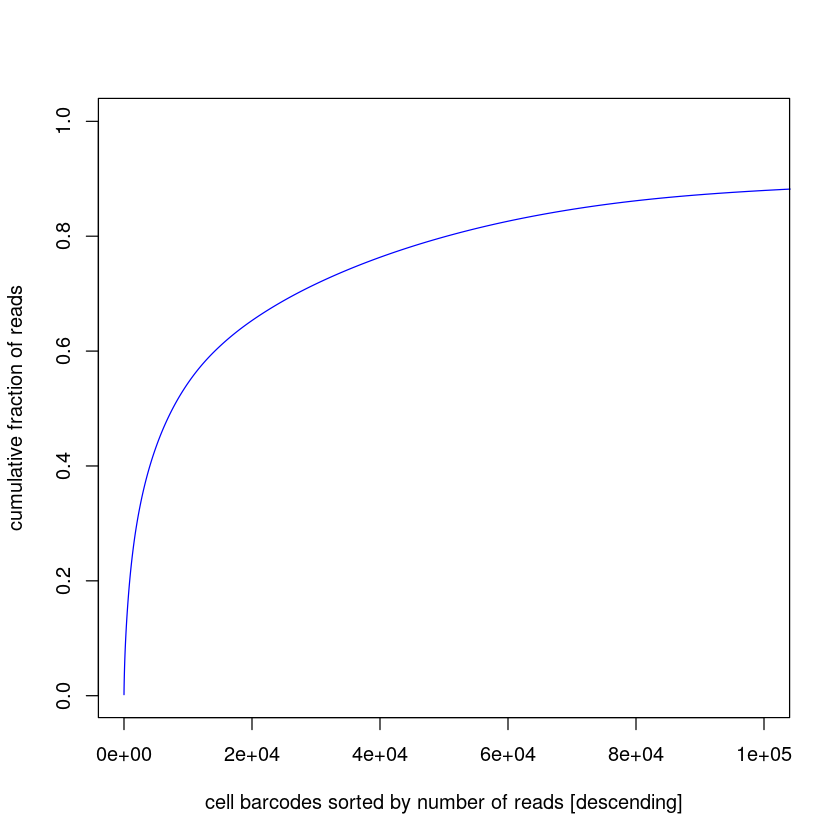

In [6]:
a=read.table("/home/bay001/scratch/cshl_2019/dropseq/steps/out_cell_readcounts.txt.gz", header=F, stringsAsFactors=F)
x=cumsum(a$V1)
x=x/max(x)
plot(1:length(x), x, type='l', col="blue", xlab="cell barcodes sorted by number of reads [descending]",
ylab="cumulative fraction of reads", xlim=c(1,100000))